# PANNA JAX Tutorial

In this tutorial, we will see how to train a potential with PANNA_JAX and the LATTE descriptor, and how to run molecular dynamics with this potential in JAX MD

### Setup

Let us start by making sure we have the required packages installed: please uncomment the packages you need below.

We also provide code to mount google drive if you need to do so in google colab.

We will then create a new folder and download a carbon dataset.

In [4]:
# If you need to install PANNA uncomment the following line
# !pip install "panna[JAX] @git+https://gitlab.com/PANNAdevs/panna.git"

# If you want to install jax-md
# ! pip install jax-md

# Other packages we'll use
# !pip install matplotlib
# !pip install pandas

In [ ]:
# Try loading jax_md
import jax_md
# If the package is not found, see cell above to install it
# If it gives an error about "module 'jax.random' has no attribute 'KeyArray'",
# it's just a typing issue with the latest JAX
# You can try to fix it by uncommenting the cell below (it might require tweaking)
# then trying to import again

In [ ]:
# jmdpath = !pip show jax_md | grep 'Location'
# jmdpath = str(jmdpath[0]).split()[1]+'/jax_md'
# print("Found the jax_md installation path as: ",jmdpath)
# print("Trying to patch..")
# !sed -i 's/KeyArray = random.KeyArray/KeyArray = Array/' {jmdpath}/rigid_body.py

In [232]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

import jax
import jax.numpy as jnp
import jax_md

# Let us create a directory for this tutorial
workdir = './Carbon_net'
os.makedirs(workdir, exist_ok=True)
os.chdir(workdir)

# Dowloading Carbon dataset and extracting
! wget https://zenodo.org/records/8095485/files/Carbon_60k.tgz
! tar -xzf Carbon_60k.tgz

# # Let's look at the first few lines to check the .xyz format
! head -5 Carbon_60k.xyz

16
Lattice="5.294670264615523 0.0 0.0 0.1864994654008172 4.712531858361576 0.0 -0.18637239331446645 -0.1435861629061084 5.915390933087724" Properties=species:S:1:pos:R:3:forces:R:3 config_type=Carbon energy=-4057.9831909817876 pbc="T T T"
C	0.25384078809538263	0.11417691692130146	2.348940223402666	-0.2827404484565636	1.3063078407541908	-0.621847929626536
C	1.8809199632300826	1.6196602831599207	2.317300332835377	-0.6269628792408758	-0.4547944568370986	-0.3619820582931545
C	0.272792001373521	1.6192303559344339	2.2618900201150955	1.9227081202134084	-1.7140228553533403	0.596559345168025


In [2]:
# We will pick the first 1000 configurations for training, and the following 100 for validation
! head -20504 Carbon_60k.xyz > train.xyz
! head -22616 Carbon_60k.xyz | tail -2112 > val.xyz

### Training

We will now create a small input file and briefly train the network.
The parameters are chosen to produce a reasonable potential, but not too complex so that it can be trained rather quickly.
However, it is recommended to use a GPU for this step, if possible.

For more information about the training parameters, please refer to the general PANNA documentation.

The only parameters we want to mention here are `at_mod` and `pair_mod`, that control the padding of total number of atoms and pairs in a batch, respectively, as an integer multiple of the specified value. This is because the training function is jit compiled, and this allows us to control the trade-off between number of compiled functions and size of the padding.


In [213]:
# Creating an input file. Edit this if you want to modify some of the training parameters
with open("train.ini", "w") as f:
    f.write(
'''[IO_INFORMATION]
train_dir = .
data_dir = ./train.xyz
val_data_dir = ./val.xyz
load_weights = False
metrics = MAE

[DATA_INFORMATION]
input_format = xyz
atomic_sequence = C
output_offset = -253.68

[MODEL_INFORMATION]
model_type = MLP
architecture = 256:128:1
descriptor_type = LATTE
pair_mod = 2000
at_mod = 200
Rc = 4.0
sig = 1.0
learnsig = False
descriptor_shape = 64,-:64,i,i:64,ij,ij:64,i,j,ij

[TRAINING_PARAMETERS]
batch_size = 20
learning_rate = const:1e-3:3000,exp:1e-3:1e-1:1000
l1_coef = 0.001
max_epochs = 20
steps_per_epoch = 200
forces_cost = 10.0
''')

In [214]:
# Training the model
! panna_jax -c train.ini

INFO - 
    ____   _    _   _ _   _    _           
   |  _ \ / \  | \ | | \ | |  / \     
   | |_) / _ \ |  \| |  \| | / _ \     
   |  __/ ___ \| |\  | |\  |/ ___ \    
   |_| /_/   \_\_| \_|_| \_/_/   \_\ 

 Properties from Artificial Neural Network Architectures

INFO - reading train.ini
2025-01-05 16:31:42.923965: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
Initializing random weights with key:  [ 0 42]
Epoch:  1 step:  200 dt: 287.952 ms Epoch time:  00:00:31  loss:  26.912037 MAE/at: 0.14727256  MAEF: 0.8916788
         Val_MAE/at: 0.13284858 Val_MAEF: 0.86340535 
Epoch:  2 step:  400 dt: 37.982 ms Epoch time:  00:00:10  loss:  38.83964 MAE/at: 0

You will notice that the first few steps are slower, as more padded batch shapes are compiled. Then the speed increases as we can reuse the jitted functions.

At the end of each epoch the potential is tested on the validation set. We can see the error in energies and forces decreasing.

The training produces a `models` folder that contains the weights of the network after every epoch, and a `metrics.dat` file with the summary of training and validation errors.

In [215]:
! ls models
print()
! head -3 metrics.dat

epoch_10_step_2000.pkl	epoch_17_step_3400.pkl	epoch_4_step_800.pkl
epoch_11_step_2200.pkl	epoch_18_step_3600.pkl	epoch_5_step_1000.pkl
epoch_12_step_2400.pkl	epoch_19_step_3800.pkl	epoch_6_step_1200.pkl
epoch_13_step_2600.pkl	epoch_1_step_200.pkl	epoch_7_step_1400.pkl
epoch_14_step_2800.pkl	epoch_20_step_4000.pkl	epoch_8_step_1600.pkl
epoch_15_step_3000.pkl	epoch_2_step_400.pkl	epoch_9_step_1800.pkl
epoch_16_step_3200.pkl	epoch_3_step_600.pkl	opt_state.pkl

#epoch	step	MAE/at	MAEF	Val_MAE/at	Val_MAEF
1	200	0.14727256	0.8916788	0.13284858	0.86340535
2	400	0.20747425	0.7806521	0.17236964	0.78475004


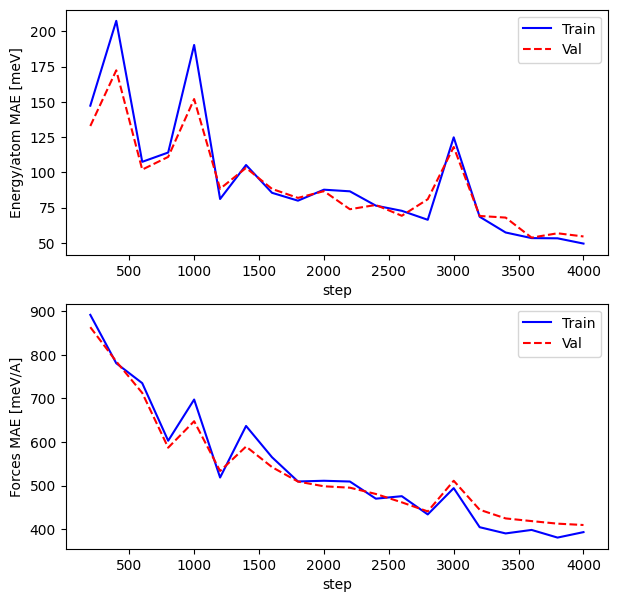

In [216]:
# Let us plot the training and validation errors
data = pd.read_csv('metrics.dat', sep="\t")
fig, ax = plt.subplots(2,1, figsize=(7, 7))
for i in range(2):
    ax[i].set_xlabel('step')

ax[0].set_ylabel('Energy/atom MAE [meV]')
ax[0].plot(data['step'],1000*data['MAE/at'],'b-',label='Train')
ax[0].plot(data['step'],1000*data['Val_MAE/at'],'r--',label='Val')
ax[0].legend()

ax[1].set_ylabel('Forces MAE [meV/A]')
ax[1].plot(data['step'],1000*data['MAEF'],'b-',label='Train')
ax[1].plot(data['step'],1000*data['Val_MAEF'],'r--',label='Val')
ax[1].legend()

### Using the potential

We can now load this potential to perform a simulation with JAX MD.

We will first set up a simple simulation starting from one of the cells in the dataset, then load the last potential and run some NVT steps.

In [234]:
# Let us load the first configuration from the validation set
# then create a few images to avoid issues with the minimum image convention
with open('val.xyz', 'r') as f:
    conf = f.readlines()[1:26]
lattice = np.asarray([float(x) for x in conf[0].split('"')[1].split()]).reshape(3,3)
# We swap axes x and z to get an upper-triangular cell
lattice = np.asarray(lattice[::-1,[2,1,0]])
print("Original cell:\n",lattice)
original_positions = np.asarray([[float(x) for x in l.split()[1:4]] for l in conf[1:]])
# Swapping positions here too
original_positions = np.asarray(original_positions[:,[2,1,0]])

positions = []
# Copies in each direction
Ncopies = 2
for i in range(Ncopies):
    for j in range(Ncopies):
        for k in range(Ncopies):
            shift = i*lattice[0]+j*lattice[1]+k*lattice[2]
            positions.append(original_positions+shift)

# Making the cell bigger too
lattice = lattice*Ncopies
print("Supercell:\n",lattice)

positions = np.concatenate(positions,axis=0)
# Move to fractional coordinates
positions = positions@np.linalg.inv(lattice)
print("Positions shape (nats,3): ",positions.shape)

nats = positions.shape[0]
species = ['C']*nats
masses = jnp.asarray([12.011]*nats)

Original cell:
 [[ 6.84381558  0.2302977  -0.12076297]
 [ 0.          4.71729674  0.07973669]
 [ 0.          0.          4.74566633]]
Supercell:
 [[13.68763117  0.46059539 -0.24152594]
 [ 0.          9.43459348  0.15947337]
 [ 0.          0.          9.49133266]]
Positions shape (nats,3):  (192, 3)


In [235]:
# We create the displacement function
displacement_fn, shift_fn = jax_md.space.periodic_general(lattice, fractional_coordinates=True)

In [236]:
# To load the potential, we need to add a couple of lines to the input file to specify which weights to load:
with open("train.ini", "r") as f:
    lines = f.readlines()
lines[4] = "load_weights = True\n"
# Please modify the following line if you want to load a different weights file
lines.insert(5, "weights_file = models/epoch_20_step_4000.pkl\n")
with open("pot.ini", "w") as f:
    f.write(''.join(lines))

In [237]:
# We can now load the potential to JAX MD
from panna.interfaces.jaxMD import PANNAJAX_neighbor_list
neighbor_fn, energy_fn, force_fn = PANNAJAX_neighbor_list(displacement_fn, './pot.ini', species, lattice)

INFO - reading ./pot.ini


In [238]:
# First neigh allocation and call for jit compilation
neighbors = neighbor_fn.allocate(positions)
_ = force_fn(positions, neighbors)

# Initializing the NVT integrator
init_fn, apply_fn = jax_md.simulate.nvt_langevin(force_fn, shift_fn, dt=1e-3, kT=0.02)
state = init_fn(jax.random.PRNGKey(42), positions, mass=masses, kT=0.02, neighbors=neighbors)
# init_fn, apply_fn = jax_md.simulate.nvt_nose_hoover(force_fn, shift_fn, dt=1e-3, kT=0.02)
# state = init_fn(jax.random.PRNGKey(42), positions, mass=masses, neighbors=neighbors)
# init_fn, apply_fn = jax_md.simulate.nve(force_fn, shift_fn, dt=1e-3)
# state = init_fn(jax.random.PRNGKey(42), positions, mass=masses, kT=0.00, neighbors=neighbors)

# Jitting the function for one timestep
@jax.jit
def body_fn(i, state):
    state, nbrs = state
    nbrs = nbrs.update(state.position)
    state = apply_fn(state, neighbors=nbrs)
    return state, nbrs

In [239]:
# Testing a couple of steps of dynamics
print(state.position[0])
new_state, neighbors = jax.lax.fori_loop(0, 2, body_fn, (state, neighbors))
print(new_state.position[0])

[0.07345393 0.46101487 0.04465396]
[0.0734587  0.46101665 0.04464618]


In [240]:
# We can now run a longer dynamics, made of several jitted jumps
jump_steps = 100
jump_total = 100
traj = [state.position]
step = 0

t1 = time.time()
while step < jump_total:
    # Running a trial step
    new_state, neighbors = jax.lax.fori_loop(0, jump_steps, body_fn, (state, neighbors))
    # Checking that neighbor list did not overflow
    if neighbors.did_buffer_overflow:
        print('Neighbor list overflowed, reallocating.', flush=True)
        neighbors = neighbor_fn.allocate(state.position)
    # Saving intermediate values
    else:
        state = new_state
        step += 1
        # print("Step {}, total energy {}".format(ctst,energy_fn(state.position, neighbors)+0.5*np.sum(state.velocity**2)))
        if step%10==0:
            print("Time: {} fs, total_energy: {}".format(step*jump_steps, energy_fn(state.position, neighbors)+0.5*np.sum(state.velocity**2) ))
        traj.append(state.position)
t2 = time.time()
print("Simulation finished, total time: {} s".format(t2-t1))
print("Time/step: {} ms".format(1000*(t2-t1)/(jump_total*jump_steps)))
print("Time/step/atom: {} us".format(1000*(t2-t1)*(1000/nats)/(jump_total*jump_steps)))

Time: 1000 fs, total_energy: -48696.46875
Time: 2000 fs, total_energy: -48695.0859375
Time: 3000 fs, total_energy: -48694.78125
Time: 4000 fs, total_energy: -48695.59375
Time: 5000 fs, total_energy: -48695.26171875
Time: 6000 fs, total_energy: -48695.70703125
Time: 7000 fs, total_energy: -48695.7734375
Time: 8000 fs, total_energy: -48695.44921875
Time: 9000 fs, total_energy: -48696.6640625
Time: 10000 fs, total_energy: -48695.21484375
Simulation finished, total time: 25.05091619491577 s
Time/step: 2.5050916194915773 ms
Time/step/atom: 13.047352184851963 us


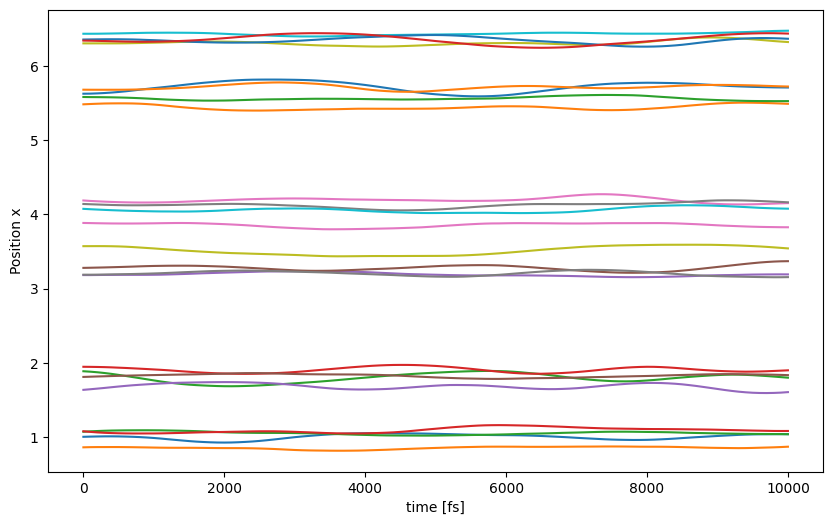

In [241]:
# Plotting the trajectory for some atoms
# Let us plot the training and validation errors
fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.set_xlabel('time [fs]')
ax.set_ylabel('Position x')
rs_traj = np.asarray(traj)@lattice
for i in range(24):
    ax.plot(jump_steps*np.arange(jump_total+1),rs_traj[:,i,0])

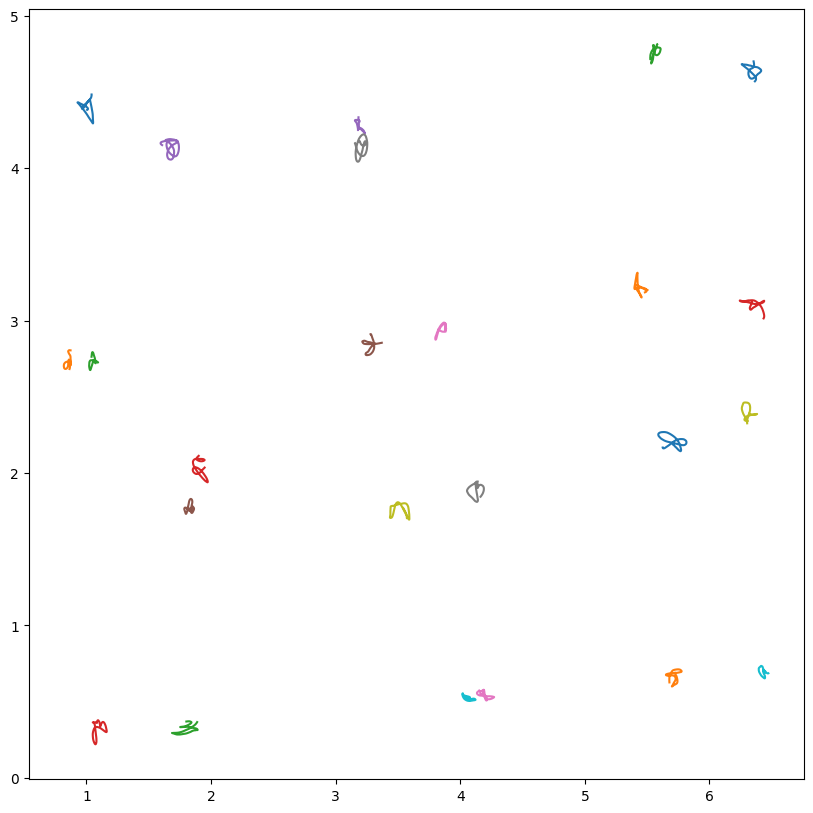

In [242]:
# Plotting in the xy plane:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
traj = np.asarray(traj)
for i in range(24):
    ax.plot(rs_traj[:,i,0],rs_traj[:,i,1])

In [244]:
# Uncomment the next lines to clean up the workspace
# os.chdir('..')
# ! rm -rf ./Carbon_net